In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from keras.regularizers import l2
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from random import seed
from random import choice
from tqdm import tqdm

<h1>Function Library</h2>

In [224]:
def build_muti_output_model(input_size, stage_1_hidden_layers, stage_2_hidden_layers, 
                            stage_1_neurons, stage_2_neurons, l2, dropout_rate):
    input_size=input_size
    stage1_counter = 0
    stage2_counter = 0
    input_layer = keras.layers.Input(input_size, 
                                     name="input")
    while stage1_counter < (stage_1_hidden_layers):
        if stage1_counter == 0:
            x = keras.layers.Dense(stage_1_neurons, activation="relu", 
                                   kernel_regularizer=regularizers.l2(l2)
                                  )(input_layer)
            x = keras.layers.Dropout(dropout_rate)(x)
            stage1_counter += 1
        else:
            x = keras.layers.Dense(stage_1_neurons, activation="relu",
                                  kernel_regularizer=regularizers.l2(l2)
                                  )(x)
            x = keras.layers.Dropout(dropout_rate)(x)
            stage1_counter += 1    
    count_output = keras.layers.Dense(1, activation="sigmoid",
                                      name="count_output")(x)
    while stage2_counter < (stage_2_hidden_layers):
        if stage1_counter == 0:
            x = keras.layers.Dense(stage_2_neurons, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
                                   kernel_regularizer=regularizers.l2(l2)
                                  )(count_output)
            x = keras.layers.Dropout(dropout_rate)(x)
            stage2_counter += 1
        else:
            x = keras.layers.Dense(stage_2_neurons, activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                  kernel_regularizer=regularizers.l2(l2)
                                  )(x)
            x = keras.layers.Dropout(dropout_rate)(x)
            stage2_counter += 1
    class_output = keras.layers.Dense(4, activation="softmax",
                                      name="class_output")(x)
    model = keras.Model(inputs=input_layer, outputs=[count_output, class_output]) 
    return model


def generate_configuration(first_stage_hl, second_stage_hl, first_stage_n, second_stage_n, 
                           learning_rate, l2, dropout_rate):
    c0 = choice(first_stage_hl)
    c1 = choice(second_stage_hl)
    c2 = choice(first_stage_n)
    c3 = choice(second_stage_n)
    c4 = choice(learning_rate)
    c5 = choice(l2)
    c6 = choice(dropout_rate)
    configuration = [c0, c1, c2, c3, c4, c5, c6]
    return configuration


def monte_carlo_tuning(x_train, y_train_1, y_train_2,
                       runs, n_samples):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          mode='min', verbose=0, patience=0, restore_best_weights=True)
    config_cache_loss = {}
    config_cache_count = {}
    config_cache_area = {}
    for _ in tqdm(range(runs)):
        configuration = generate_configuration(first_stage_hl, second_stage_hl, first_stage_n, 
                                               second_stage_n, learning_rate, l2, dropout_rate)
        if all(configuration) not in config_cache_loss:
            sample_loss_cache = []
            for i in range(n_samples):
                model = build_muti_output_model(configuration[0], configuration[1],
                                               configuration[2], configuration[3], 
                                                configuration[5], configuration[6])
                opt = tf.keras.optimizers.Adam(
                                learning_rate = configuration[4],
                            )
                model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
                                                optimizer=opt,
                                                loss_weights=[0.5, 0.5])
                history = model.fit(x_train, [y_train_1, y_train_2], 
                    epochs=7,
                    validation_split=0.2,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2),
                    verbose=0)   
                sample_loss = history.history['val_loss'][-1]
                sample_loss_cache.append(sample_loss)
            loss = sum(sample_loss_cache)/n_samples
            config_cache_loss[str(configuration)]  = loss
    return config_cache_loss


# given a datalist and a number of breakpoints, this function finds the break point values such that the
# variance in each category is minimised. This code is inspired by: https://gist.github.com/drewda/1299198
# The code at the link provided does not work properly, however changes have been made here to fix it. 

def getJenksBreaks(dataList, numClass):
    dataList = list(dataList)
    dataList.sort()
    mat1 = []
    for i in range(0,len(dataList)+1):
        temp = []
        for j in range(0,numClass+1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(0,len(dataList)+1):
        temp = []
        for j in range(0,numClass+1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1,numClass+1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2,len(dataList)+1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2,len(dataList)+1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1,l+1):
            i3 = l - m + 1
            val = float(dataList[i3-1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2,numClass+1):
                    if mat2[l][j] >= (v + mat2[i4][j - 1]):
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(dataList)
    breaks = []
    for i in range(0,numClass+1):
        breaks.append(min(dataList))
    countNum = numClass

    while countNum >= 2:#print "rank = " + str(mat1[k][countNum])
        id = int((mat1[k][countNum]) - 2)
        value = dataList[id]
        breaks.append(value)
        k = int((mat1[k][countNum] - 1))
        countNum -= 1
    breaks.append(max(dataList))
    breaks = list(set(breaks))
    breaks.sort()
    return(breaks)
    # The first output number is the smallest value in the input
    # Following output numbers are inclusive upper bounds


# The next two functions are used to determine the goodness of variance fit, determining how well the function above
# performed (in other words, it measures how well using a specific number of breakpoints applies to the data)
# This code is informed by a stack exchange comment availible at this link:
# https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks

def goodness_of_variance_fit(array, nclasses):
    
        classes = getJenksBreaks(array, nclasses)
        classified = np.array([classify(i, classes) for i in array])
        maxz = max(classified)
        zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]
        sdam = np.sum((array - array.mean()) ** 2)
        array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]
        sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])
        gvf = (sdam - sdcm) / sdam
        return gvf, classes
    
def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1


# This function iterates over various numbers of breakpoints and uses the function above to find the best 
# number of break points

def optimal_classes(data, gvf_threshold, min_classes):

    gvf= 0.0
    nclasses = min_classes

    while gvf < gvf_threshold:
            gvf, classes = goodness_of_variance_fit(data, nclasses)
            if gvf < gvf_threshold:
                gvf, classes = goodness_of_variance_fit(data, nclasses)
                print('Classes Trialed: ', nclasses)
                print('gvf value :', gvf)
                print('Outcome: gvf value insufficient, further trials will be attempted')
                print()
                nclasses += 1
            else:
                print('Classes Trialed: ', nclasses)
                print('gvf value: ', gvf)
                print('Outcome: gvf value broke threshold, breaks found.')
                print('Breaks: ', classes)
    return classes
                

def plot_multiclass_roc(y_test, y_pred, n_classes, figsize=(17, 6)):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Each Class')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.6f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
#     plt.savefig("class_model_ROC.pdf")
    plt.show()
    

# def loss_weight_ratio_testing(input_model, ratio_increase):
#     weight_1 = 0
#     weight_2 = 1-weight_1
#     count_roc =[]
#     class_ovr_w_roc =[]
#     class_ovr_m_roc = []
#     class_ovo_w_roc = []
#     model_histories = []
#     weight_ratio = []
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
#     while weight_1 <= 1:
#         model = input_model
#         opt = tf.keras.optimizers.Adam(
#                                 learning_rate= 1e-5,
#                             )
#         model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
#               optimizer=opt,
#               loss_weights=[weight_1, weight_2])
#         history = model.fit(x_train, [y_train_count, y_train], 
#                 epochs=2,
#                 verbose=1,
#                 validation_split=0.2,
#                 callbacks=[es])
#         y_pred=model.predict(x_test)
#         count_predictions = y_pred[0]
#         area_predictions = y_pred[1]
#         c_auc = roc_auc_score(y_test_count, count_predictions)
#         w_ovr  = roc_auc_score(y_test_area, area_predictions, multi_class="ovr",
#                               average="weighted")
#         # summarize scores
#         print('Count Weight: ', weight_1, 'Class Weight: ', weight_2)
#         print('Count ROC AUC=%.6f' % (c_auc))
#         print('Class Weighted OVR ROC:', w_ovr)
#         print()                  
#         count_roc.append(c_auc)
#         class_ovr_w_roc.append(w_ovr)
#         model_histories.append(history)
#         wr = 0
#         if weight_2 == 0:
#             weight_ratio.append(wr)
#         else:
#             wr = (weight_1/weight_2)
#             weight_ratio.append(wr)
#         weight_1 += ratio_increase
#         weight_2 = 1-weight_1
#     return count_roc, class_ovr_w_roc, model_histories

def loss_weight_ratio_testing(input_model, ratio_increase):
    weight_1 = 0
    weight_2 = 10-weight_1
    count_roc =[]
    class_ovr_w_roc =[]
    class_ovr_m_roc = []
    class_ovo_w_roc = []
    model_histories = []
    weight_ratio = []
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
    while weight_1 <= 10:
        model = input_model
        opt = tf.keras.optimizers.Adam(
                                learning_rate= 1e-4,
                            )
        model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
              optimizer=opt,
              loss_weights=[weight_1, weight_2])
        history = model.fit(x_train, [y_train_count, y_train], 
                epochs=10,
                verbose=0,
                validation_split=0.2,
                callbacks=[es])
        y_pred=model.predict(x_test)
        count_predictions = y_pred[0]
        area_predictions = y_pred[1]
        c_auc = roc_auc_score(y_test_count, count_predictions)
        w_ovr  = roc_auc_score(y_test_area, area_predictions, multi_class="ovr",
                              average="weighted")
        # summarize scores
        print('Count Weight: ', weight_1, 'Class Weight: ', weight_2)
        print('Count ROC AUC=%.6f' % (c_auc))
        print('Class Weighted OVR ROC:', w_ovr)
        print()                  
        count_roc.append(c_auc)
        class_ovr_w_roc.append(w_ovr)
        model_histories.append(history)
        wr = 0
        if weight_2 == 0:
            weight_ratio.append(wr)
        else:
            wr = (weight_1/weight_2)
            weight_ratio.append(wr)
        weight_1 += ratio_increase
        weight_2 = 10-weight_1
    return count_roc, class_ovr_w_roc, model_histories

<h1>Load & Preprocess Data</h1>

In [227]:
data = pd.read_csv("landslide_data.csv") 

In [228]:
# First step is to use Fischer-Jenks to get the area classes

# Create a df of non-zero Area_Slide
filtered_data = data[data['Area_Slide'] > 0]
non_zero_slide_area = filtered_data['Area_Slide']
non_zero_slide_area = np.array(non_zero_slide_area)

# Find the optimal breaks in non-zero Area_Slide, gvf threshold of 0.85, start by trying two classes
optimal_classes = optimal_classes(non_zero_slide_area, 0.85, 2)

Classes Trialed:  2
gvf value : 0.46050718623636394
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  3
gvf value : 0.6952104045936166
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  4
gvf value : 0.8214648221273643
Outcome: gvf value insufficient, further trials will be attempted

Classes Trialed:  5
gvf value:  0.8716217149500437
Outcome: gvf value broke threshold, breaks found.
Breaks:  [0.054691, 2981.98645, 10821.34832, 29509.81466, 82850.15392, 182966.8526]


In [229]:
# Apply a class value to each record based on the above results
data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < optimal_classes[0]), "Slide_Class"] = "Class 0" 
data.loc[(data["Area_Slide"] >= optimal_classes[0]) & (data["Area_Slide"] <= optimal_classes[1]), "Slide_Class"] = "Class 1" 
data.loc[(data["Area_Slide"] > optimal_classes[1]) & (data["Area_Slide"] <= optimal_classes[2]), "Slide_Class"] = "Class 2" 
data.loc[(data["Area_Slide"] > optimal_classes[2]) & (data["Area_Slide"] <= optimal_classes[3]), "Slide_Class"] = "Class 3" 
data.loc[(data["Area_Slide"] > optimal_classes[3]) & (data["Area_Slide"] <= optimal_classes[4]), "Slide_Class"] = "Class 4"
data.loc[(data["Area_Slide"] > optimal_classes[4]) & (data["Area_Slide"] <= optimal_classes[5]), "Slide_Class"] = "Class 5"
data["Slide_Class"].value_counts()

# Observe: 1) The imbalanced distribution, and 2) Class 5 only has one record

Class 0    119932
Class 1      6517
Class 2       768
Class 3       137
Class 4        14
Class 5         1
Name: Slide_Class, dtype: int64

In [230]:
# Merge select classes
data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < optimal_classes[0]), "Slide_Class"] = "Class 0" 
data.loc[(data["Area_Slide"] >= optimal_classes[0]) & (data["Area_Slide"] <= optimal_classes[2]), "Slide_Class"] = "Class 1"
data.loc[(data["Area_Slide"] > optimal_classes[2]) & (data["Area_Slide"] <= optimal_classes[3]), "Slide_Class"] = "Class 2" 
data.loc[(data["Area_Slide"] > optimal_classes[3]) & (data["Area_Slide"] <= optimal_classes[5]), "Slide_Class"] = "Class 3"
data["Slide_Class"].value_counts()

Class 0    119932
Class 1      7285
Class 2       137
Class 3        15
Name: Slide_Class, dtype: int64

In [124]:
### REMOVE ###
# data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < 0.054691), "Slide_Class"] = "Class 0" 
# data.loc[(data["Area_Slide"] >= 0.054691) & (data["Area_Slide"] <= 2981.98645), "Slide_Class"] = "Class 1" 
# data.loc[(data["Area_Slide"] > 2981.98645) & (data["Area_Slide"] <= 10821.34832), "Slide_Class"] = "Class 1" 
# data.loc[(data["Area_Slide"] > 10821.34832) & (data["Area_Slide"] <= 29509.81466), "Slide_Class"] = "Class 2" 
# data.loc[(data["Area_Slide"] > 29509.81466) & (data["Area_Slide"] <= 82850.15392), "Slide_Class"] = "Class 3"
# data.loc[(data["Area_Slide"] > 82850.15392) & (data["Area_Slide"] <= 182966.8526), "Slide_Class"] = "Class 3"
# data["Slide_Class"].value_counts()

Class 0    119932
Class 1      7285
Class 2       137
Class 3        15
Name: Slide_Class, dtype: int64

In [221]:
# Define dependant and explanatory variables
data_y = data['Slide_Class']
data_x = data.drop(['SU_ID', 'Count', 'Area_Slide', 'Slide_Class'], axis=1)
data_x = data_x.astype(float)


# Train/Test split
x_train, x_test, y_train_area, y_test_area = train_test_split(data_x, data_y, test_size=0.2, random_state=0)


# Standardize the explanatory variables
scaler = preprocessing.StandardScaler()

train_x_values = x_train.values
x_scaled1 = scaler.fit_transform(train_x_values)
x_train = pd.DataFrame(x_scaled1)

test_x_values = x_test.values
x_scaled2 = scaler.fit_transform(test_x_values)
x_test = pd.DataFrame(x_scaled2)


# Use SMOTE package to oversample training data
oversample = SMOTE()
x_train, y_train_area = oversample.fit_resample(x_train, y_train_area)


# Use the Slide_Class field to create a binary variable that 
# indicates whether or not there is a landslide in any capacity
y_train_count = []
y_test_count = []
for i in y_train_area:
    if i == "Class 0":
        y_train_count.append(0)
    else:
        y_train_count.append(1)
        
for i in y_test_area:
    if i == "Class 0":
        y_test_count.append(0)
    else:
        y_test_count.append(1)     
y_train_count = np.array(y_train_count)
y_test_count = np.array(y_test_count)


# encode class values as integers
encoder = LabelEncoder()

# encode training
encoder.fit(y_train_area)
encoded_Y = encoder.transform(y_train_area)
y_train_area = np_utils.to_categorical(encoded_Y)

# encode testing
# encoder.fit(y_test_area)
# encoded_Y_test = encoder.transform(y_test_area)
# y_test_area = np_utils.to_categorical(encoded_Y_test)

<h1>Modelling</h1>

In [126]:
# Define the search space for MC tuning
first_stage_hl  = [6, 12, 18, 24, 48]
second_stage_hl = [6, 12, 18, 24]
first_stage_n   = [4, 8, 16, 32, 64]
second_stage_n  = [4, 8, 16, 32, 64]
learning_rate   = [1e-2, 1e-3, 1e-4]
l2              = [1e-3, 1e-4, 1e-5]
dropout_rate    = [0.2, 0.4, 0.6, 0.8]

In [163]:
# USE MONTE CARLO TUNING FUNCTION 

# uncomment the code below to run the montecarlo tuner. Be advised, this process takes an ex and you may prefer to 
# simply reuse the values in the report. 

# config_cache = monte_carlo_tuning(x_train, y_train_count, y_train_area, runs=1000, n_samples=5)
# optimal_parameters = min(config_cache, key=config_cache.get)

optimal_parameters = [6, 12, 32, 4, 1e-4, 0.2]

In [162]:
lwr_model = build_muti_output_model(*optimal_parameters)

In [ ]:
co, cl, mh = loss_weight_ratio_testing(lwr_model, 0.1)

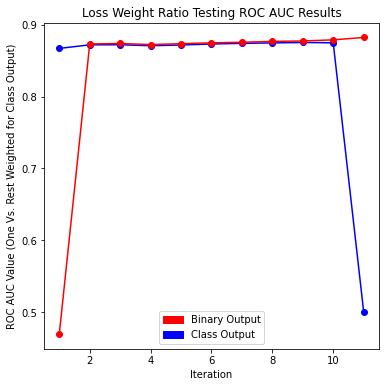

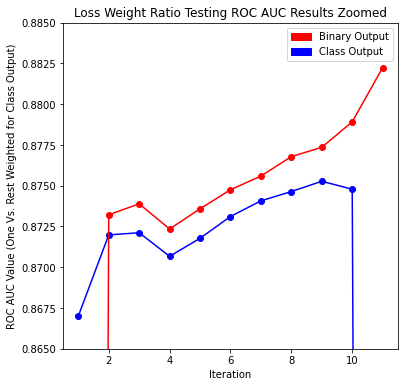

In [180]:
iteration = list(range(1,12))
co = [0.4697642202160677,
  0.8732161398821352,
  0.8738895262157222,
  0.872348897639263,
  0.8735841626784037,
  0.8747538702127408,
  0.8755926742685977,
  0.8767841662705956,
  0.8773556105481453,
  0.8789159417536946,
  0.8822436314449064]
cl = [0.8670034294002861,
  0.8719836649189152,
  0.8721181496411214,
  0.8706711380269829,
  0.8717760611632063,
  0.8731124107537576,
  0.8740722810400376,
  0.8746425163405755,
  0.8752726948902124,
  0.8747853344452116,
  0.5008439865358839]


plt.figure(figsize=(6, 6))

plt.plot(iteration, cl, 'o-', color='blue')
plt.plot(iteration, co, 'o-', color='red')

plt.title('Loss Weight Ratio Testing ROC AUC Results')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC Value (One Vs. Rest Weighted for Class Output)')
    
red_patch = mpatches.Patch(color='red', label='Binary Output')
blu_patch = mpatches.Patch(color='blue', label='Class Output')
plt.legend(handles=[red_patch, blu_patch])

plt.show()

plt.figure(figsize=(6, 6))

plt.plot(iteration, class_roc_auc_values, 'o-', color='blue')
plt.plot(iteration, count_roc_auc_values, 'o-', color='red')

plt.ylim(0.865, 0.885)

plt.title('Loss Weight Ratio Testing ROC AUC Results Zoomed')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC Value (One Vs. Rest Weighted for Class Output)')
    
red_patch = mpatches.Patch(color='red', label='Binary Output')
blu_patch = mpatches.Patch(color='blue', label='Class Output')
plt.legend(handles=[red_patch, blu_patch])
    
plt.show()

In [193]:
baseline = LogisticRegression(solver='liblinear', random_state=0)
baseline.fit(x_train, y_train_count)
baseline_pred = baseline.predict_proba(x_test)
baseline_pred = baseline_pred[:,1]

<h2>Binary Model</h2>

In [183]:
# Define model and checkpoints
binary_model = build_muti_output_model(*optimal_parameters)

binary_model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
              optimizer='adam', loss_weights=[10, 0])

binary_checkpoint = ModelCheckpoint("Binary_Checkpoint", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

# Train model
binary_model_history = binary_model.fit(x_train, [y_train_count, y_train], 
                    epochs=30,
                    callbacks=[binary_checkpoint],
                    verbose = 1,
                    validation_split=0.2
                   )

Epoch 1/30
9583/9600 [============================>.] - ETA: 0s - loss: 2.9594 - count_output_loss: 0.2939 - class_output_loss: 1.3864
Epoch 00001: val_loss improved from inf to 0.33211, saving model to Binary_Checkpoint
INFO:tensorflow:Assets written to: Binary_Checkpoint/assets
9600/9600 [==============================] - 21s 2ms/step - loss: 2.9593 - count_output_loss: 0.2939 - class_output_loss: 1.3864 - val_loss: 0.3321 - val_count_output_loss: 0.0311 - val_class_output_loss: 1.3863
Epoch 2/30
9586/9600 [============================>.] - ETA: 0s - loss: 2.6379 - count_output_loss: 0.2616 - class_output_loss: 1.3864
Epoch 00002: val_loss improved from 0.33211 to 0.18260, saving model to Binary_Checkpoint
INFO:tensorflow:Assets written to: Binary_Checkpoint/assets
9600/9600 [==============================] - 18s 2ms/step - loss: 2.6377 - count_output_loss: 0.2616 - class_output_loss: 1.3864 - val_loss: 0.1826 - val_count_output_loss: 0.0160 - val_class_output_loss: 1.3863
Epoch 3/30

Epoch 21/30
9563/9600 [============================>.] - ETA: 0s - loss: 2.4213 - count_output_loss: 0.2381 - class_output_loss: 1.3864
Epoch 00021: val_loss did not improve from 0.08163
9600/9600 [==============================] - 14s 1ms/step - loss: 2.4212 - count_output_loss: 0.2381 - class_output_loss: 1.3864 - val_loss: 0.1032 - val_count_output_loss: 0.0062 - val_class_output_loss: 1.3863
Epoch 22/30
9600/9600 [==============================] - ETA: 0s - loss: 2.4299 - count_output_loss: 0.2389 - class_output_loss: 1.3864
Epoch 00022: val_loss did not improve from 0.08163
9600/9600 [==============================] - 13s 1ms/step - loss: 2.4299 - count_output_loss: 0.2389 - class_output_loss: 1.3864 - val_loss: 0.1604 - val_count_output_loss: 0.0119 - val_class_output_loss: 1.3863
Epoch 23/30
9564/9600 [============================>.] - ETA: 0s - loss: 2.4249 - count_output_loss: 0.2383 - class_output_loss: 1.3864
Epoch 00023: val_loss did not improve from 0.08163
9600/9600 [====

Baseline:     ROC AUC=0.823354
Binary Model: ROC AUC=0.886198


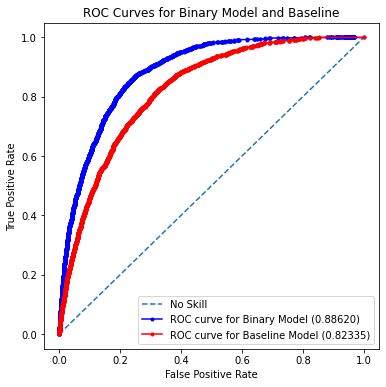

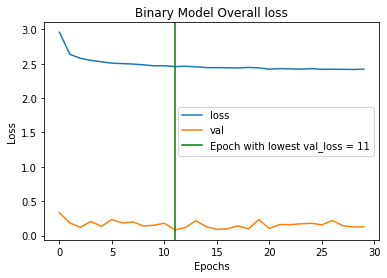

In [213]:
# load model
best_binary_model = tensorflow.keras.models.load_model('Binary_Checkpoint')

# Make predictions
binary_y_pred=best_binary_model.predict(x_test)
binary_count_predictions = binary_y_pred[0]
binary_area_predictions = binary_y_pred[1]

binary_auc = roc_auc_score(y_test_count, binary_count_predictions)
baseline_auc = roc_auc_score(y_test_count, baseline_pred)
print('Baseline:     ROC AUC=%.6f' % (baseline_auc))
print('Binary Model: ROC AUC=%.6f' % (binary_auc))

plt.figure(figsize=(6, 6))
ns_probs = [0 for _ in range(len(y_test_count))]
ns1, ns2, _ = roc_curve(y_test_count, ns_probs)
nn1, nn2, _ = roc_curve(y_test_count, binary_count_predictions)
bl1, bl2, _ = roc_curve(y_test_count, baseline_pred)
# bl1, bl2, _ = roc_curve(y_test_count, p_pred)
plt.plot(ns1, ns2, linestyle='--', label='No Skill')
plt.plot(nn1, nn2, marker='.', color='blue',label='ROC curve for Binary Model ('+'%.5f' % (binary_auc)+')')
plt.plot(bl1, bl2, marker='.', color='red', label='ROC curve for Baseline Model ('+'%.5f' % (baseline_auc)+')')

# axis labels
plt.title('ROC Curves for Binary Model and Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.plot(figsize=(6, 12))
plt.show()

best_epochs_b = np.argmin(binary_model_history.history['val_loss'])

history = binary_model_history
plt.subplot()
plt.title('Binary Model Overall loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val')
plt.axvline(x=best_epochs_b, label='Epoch with lowest val_loss = ' + '%.0f' % (best_epochs_b), color='green')
plt.legend()
# plt.savefig("binary_model_loss.pdf")

<h2>Class Model</h2>

In [190]:
# Define model and checkpoints
class_model = build_muti_output_model(*optimal_parameters)

class_model.compile(loss=["binary_crossentropy", "categorical_crossentropy"], 
              optimizer='adam', loss_weights=[8, 2]) # How to access best weights

class_checkpoint = ModelCheckpoint("Class_Checkpoint", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

# Train model
class_model_history = class_model.fit(x_train, [y_train_count, y_train], 
                    epochs=35,
                    callbacks=[class_checkpoint],
                    verbose = 1,
                    validation_split=0.2
                   )

Epoch 1/35
9566/9600 [============================>.] - ETA: 0s - loss: 4.3795 - count_output_loss: 0.2952 - class_output_loss: 0.9955
Epoch 00001: val_loss improved from inf to 4.16374, saving model to Class_Checkpoint
INFO:tensorflow:Assets written to: Class_Checkpoint/assets
9600/9600 [==============================] - 18s 2ms/step - loss: 4.3787 - count_output_loss: 0.2952 - class_output_loss: 0.9952 - val_loss: 4.1637 - val_count_output_loss: 0.0132 - val_class_output_loss: 2.0140
Epoch 2/35
9579/9600 [============================>.] - ETA: 0s - loss: 3.7704 - count_output_loss: 0.2635 - class_output_loss: 0.8149
Epoch 00002: val_loss improved from 4.16374 to 3.86389, saving model to Class_Checkpoint
INFO:tensorflow:Assets written to: Class_Checkpoint/assets
9600/9600 [==============================] - 17s 2ms/step - loss: 3.7716 - count_output_loss: 0.2636 - class_output_loss: 0.8150 - val_loss: 3.8639 - val_count_output_loss: 0.0093 - val_class_output_loss: 1.8774
Epoch 3/35
957

9564/9600 [============================>.] - ETA: 0s - loss: 3.3006 - count_output_loss: 0.2473 - class_output_loss: 0.6255
Epoch 00019: val_loss did not improve from 0.16890
9600/9600 [==============================] - 14s 1ms/step - loss: 3.3006 - count_output_loss: 0.2473 - class_output_loss: 0.6255 - val_loss: 0.3478 - val_count_output_loss: 3.8592e-04 - val_class_output_loss: 0.1365
Epoch 20/35
9562/9600 [============================>.] - ETA: 0s - loss: 3.2963 - count_output_loss: 0.2458 - class_output_loss: 0.6291
Epoch 00020: val_loss did not improve from 0.16890
9600/9600 [==============================] - 14s 1ms/step - loss: 3.2962 - count_output_loss: 0.2458 - class_output_loss: 0.6288 - val_loss: 0.2879 - val_count_output_loss: 0.0011 - val_class_output_loss: 0.1032
Epoch 21/35
9587/9600 [============================>.] - ETA: 0s - loss: 3.3146 - count_output_loss: 0.2470 - class_output_loss: 0.6327
Epoch 00021: val_loss improved from 0.16890 to 0.15032, saving model to Cl

One-vs-One ROC AUC scores:
0.739996 (macro),
0.893249 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.885337 (macro),
0.879125 (weighted by prevalence)


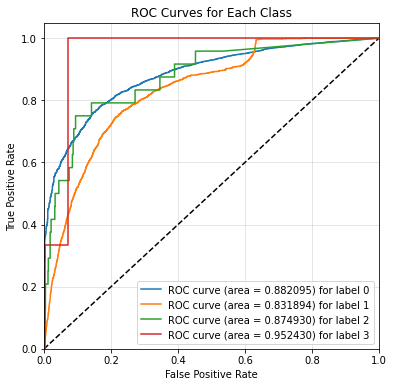

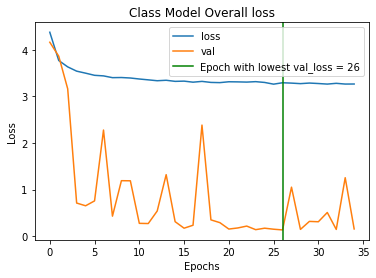

In [225]:
# load best model
best_class_model = tensorflow.keras.models.load_model('Class_Checkpoint')

# Make predictions
class_y_pred=best_class_model.predict(x_test)
class_count_predictions = class_y_pred[0]
class_area_predictions = class_y_pred[1]

# Test Predictions
macro_roc_auc_ovo = roc_auc_score(y_test_area, class_area_predictions, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_area, class_area_predictions, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_area, class_area_predictions, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_area, class_area_predictions, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

plot_multiclass_roc(y_test_area, class_area_predictions, n_classes=4, figsize=(6, 6))

best_epoch = np.argmin(class_model_history.history['val_loss'])

history = class_model_history
plt.subplot()
plt.title('Class Model Overall loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val')
plt.axvline(x=best_epoch, label='Epoch with lowest val_loss = ' + '%.0f' % (best_epoch), color='green')
plt.legend()
# plt.savefig("class_model_loss.pdf")

<h1>Ablation Study</h1>

In [ ]:
def remove_variable(data, variable1, variable2):

    # Repeat preprocessing, but do so with one variable removed
    data.loc[(data["Area_Slide"] == 0) & (data["Area_Slide"] < 0.054691), "Slide_Class"] = "Class 0" 
    data.loc[(data["Area_Slide"] >= 0.054691) & (data["Area_Slide"] <= 2981.98645), "Slide_Class"] = "Class 1" 
    data.loc[(data["Area_Slide"] > 2981.98645) & (data["Area_Slide"] <= 10821.34832), "Slide_Class"] = "Class 1" 
    data.loc[(data["Area_Slide"] > 10821.34832) & (data["Area_Slide"] <= 29509.81466), "Slide_Class"] = "Class 2" 
    data.loc[(data["Area_Slide"] > 29509.81466) & (data["Area_Slide"] <= 82850.15392), "Slide_Class"] = "Class 3"
    data.loc[(data["Area_Slide"] > 82850.15392) & (data["Area_Slide"] <= 182966.8526), "Slide_Class"] = "Class 3"
    
    data_y = data['Slide_Class']
    data_x = data.drop(['SU_ID', 'Count', 'Area_Slide', 'Slide_Class'], axis=1)
    if variable1 == variable2:
        data_x = data_x.drop(variable1, axis=1)
        data_x = data_x.astype(float)
    else:
        data_x = data_x.drop(variable1, axis=1)
        data_x = data_x.drop(variable2, axis=1)
        data_x = data_x.astype(float)

    
    x_train, x_test, y_train_area, y_test_area = train_test_split(data_x, 
                                                                  data_y, 
                                                                  test_size=0.2, 
                                                                  random_state=0)
    
    scaler = preprocessing.StandardScaler()

    train_x_values = x_train.values
    x_scaled1 = scaler.fit_transform(train_x_values)
    x_train = pd.DataFrame(x_scaled1)

    test_x_values = x_test.values
    x_scaled2 = scaler.fit_transform(test_x_values)
    x_test = pd.DataFrame(x_scaled2)
    
    oversample = SMOTE()
    x_train, y_train_area = oversample.fit_resample(x_train, y_train_area)
    
    encoder = LabelEncoder()

    #training
    encoder.fit(y_train_area)
    encoded_Y = encoder.transform(y_train_area)
    # convert integers to dummy variables (i.e. one hot encoded)
    y_train = np_utils.to_categorical(encoded_Y)

    #testing
    encoder.fit(y_test_area)
    encoded_Y_test = encoder.transform(y_test_area)
    y_test = np_utils.to_categorical(encoded_Y_test)
    
    y_train_count = []
    y_test_count = []

    for i in y_train_area:
        if i == "Class 0":
            y_train_count.append(0)
        else:
            y_train_count.append(1)

    for i in y_test_area:
        if i == "Class 0":
            y_test_count.append(0)
        else:
            y_test_count.append(1)

    y_train_count = np.array(y_train_count)
    y_test_count = np.array(y_test_count)
    
    return x_train, x_test, y_train, y_test_area, y_train_count, y_test_count